In [2]:
# Data Handlers
import numpy as np

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim

# Other
from pathlib import Path
from os import listdir
from time import time
from sklearn.preprocessing import OneHotEncoder
from fastaniso import anisodiff

# Graphics
from matplotlib import pyplot as plt
import seaborn as sns

# Additional modules
from dataset_creator import generate_unshuffled_csv
from assistive_funcs import filtering_image, check_ssim, check_gmsd
from csv_dataloader import get_train_test_small_data

d:\Projects\PythonProjects\_venvs\3.9_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Paths
p_main_data = Path("../data/large_data")
p_models = Path("../models")

p_scv_folder = p_main_data / "csv_files"

p_train_images = p_main_data / "train_images"
p_test_images = p_main_data / "test_images"

p_train_noised_images = p_main_data / "train_images_noised"
p_test_noised_images = p_main_data / "test_images_noised"

p_train_filtered_images = p_main_data / "train_images_filtered"
p_test_filtered_images = p_main_data / "test_images_filtered"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Dataset
win_size = 5
step = 3
create_dataset = 1
train_dataset_name = f"train_W{win_size}_S{step}.csv"
test_dataset_name = f"test_W{win_size}_S{step}.csv"

In [4]:
# Train dataset
if create_dataset:
    generate_unshuffled_csv(win_size=win_size, dump_to_file=100000, step=step,
                 img_path=p_train_images,
                 datasets_path=p_scv_folder,
                 noise_imgs_path=p_train_noised_images,
                 dataset_name=train_dataset_name,
                 force_create_dataset=1)

img: 8/8
Samples: 329672


In [5]:
# Valid dataset
if create_dataset:
    generate_unshuffled_csv(win_size=win_size, dump_to_file=10000, step=step,
                 img_path=p_test_images,
                 datasets_path=p_scv_folder,
                 noise_imgs_path=p_test_noised_images,
                 dataset_name=test_dataset_name,
                 force_create_dataset=1)

img: 2/2
Samples: 82418


In [6]:
class FCBlock(nn.Module):
    def __init__(self, in_len, out_len, p_dropout=False) -> None:
        super().__init__()
        if p_dropout:
            self.fc_block = nn.Sequential(
                nn.Linear(in_len, out_len),
                nn.Dropout(p_dropout),
                nn.ReLU(),
            )
        else:
            self.fc_block = nn.Sequential(
                nn.Linear(in_len, out_len),
                nn.BatchNorm1d(out_len),
                nn.ReLU(),
            )
    
    def forward(self, x):
        return self.fc_block(x)

In [7]:
class DefaultModel(nn.Module):
    def __init__(self, in_len, out_len) -> None:
        super().__init__()
        double_in_len = in_len * 2
        triple_in_len = in_len * 3

        self.structure = nn.Sequential(
            FCBlock(in_len, in_len,               p_dropout=0),
            FCBlock(in_len, double_in_len,        p_dropout=0),
            FCBlock(double_in_len, double_in_len, p_dropout=0),
            FCBlock(double_in_len, double_in_len, p_dropout=0),
            FCBlock(double_in_len, triple_in_len, p_dropout=0),
            FCBlock(triple_in_len, triple_in_len, p_dropout=0),
            nn.Linear(triple_in_len, out_len),
        )

    def forward(self, x):
        x = self.structure(x)
        return x

In [8]:
class FitModel():
    def __init__(self, model, criterion, optimizer, scheduler,
                 p_scv_folder, train_dataset_name, test_dataset_name,
                 batch_size, device, num_epoches, classification=False):
        # Model
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        
        # Params
        self.num_epoches = num_epoches
        self.batch_size = batch_size
        
        # Folders
        self.p_scv_folder = p_scv_folder
        self.train_dataset_name = train_dataset_name
        self.test_dataset_name = test_dataset_name
        
        # Flags
        self.classification = classification
        self.device = device  
        
        # Constants
        self.train_losses = []
        self.valid_losses = []
        self.images_filtered = False
        
        if self.classification:
            X = [[i] for i in range(0, 256)]
            self.enc = OneHotEncoder()
            self.enc.fit(X)

    def _train(self, current_epoch):
        total_loss = []
        start_time = time()
        self.model.train()
        for data, targets in self.train_loader:
            data = data.to(device=self.device)
            if self.classification:
                targets = torch.Tensor(self.enc.transform(targets).toarray())
            targets = targets.to(device=self.device)

            scores = self.model(data)
            loss = self.criterion(scores, targets)
            loss.backward()
           
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            total_loss.append(loss.item())
        
        mean_total_loss = np.mean(total_loss)
        self.train_losses.append(mean_total_loss)
        print(f"Epoch: {current_epoch}/{self.num_epoches}, time: {int(time() - start_time)}s, lr = {self.scheduler.get_last_lr()}\n\tTrain loss: {mean_total_loss:.2f}")
        
    def _valid(self, current_epoch):
        total_loss = []

        self.model.eval()
        with torch.no_grad():
            for data, targets in self.test_loader:
                
                data = data.to(device=self.device)
                if self.classification:
                    targets = torch.Tensor(self.enc.transform(targets).toarray())
                targets = targets.to(device=self.device)
                
                # Forward
                scores = self.model(data)
                loss = self.criterion(scores, targets)
                total_loss.append(loss.item())
        
        mean_total_loss = np.mean(total_loss)
        self.valid_losses.append(mean_total_loss)
        print(f"\tValid loss: {mean_total_loss:.2f}")
    
    def fit(self):
        self.train_loader = get_train_test_small_data(scv_folder=self.p_scv_folder, dataset_name=self.train_dataset_name,
                                                        batch_size=self.batch_size, split=False)
        self.test_loader = get_train_test_small_data(scv_folder=self.p_scv_folder, dataset_name=self.test_dataset_name,
                                                        batch_size=self.batch_size, split=False)
        for epoch in range(self.num_epoches):
            self._train(epoch + 1)
            self._valid(epoch + 1)
            if self.scheduler is not None:
                self.scheduler.step()
                
    def plot_graph(self):
        sns.set()
        fig, (ax_train, ax_test) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
        fig.suptitle('Loss')

        ax_train.set_title("Train loss")
        ax_test.set_title("Valid loss")

        ax_train.set_ylabel('Loss value')
        ax_test.set_ylabel('Loss value')

        ax_train.set_xlabel("Batch")
        ax_test.set_xlabel("Batch")

        sns.lineplot(data=self.train_losses, ax=ax_train)
        sns.lineplot(data=self.valid_losses, ax=ax_test)

        plt.show()
    
    def filtering_all_images(self):
        self.images_filtered = True
        images_names = listdir(p_test_noised_images)
        for name in images_names:
            filtering_image(self.model, p_test_filtered_images, p_test_noised_images, name, win_size, self.device, classification=self.classification)
        
    @staticmethod
    def _check_filtering(p_target_images, p_original_images):
        ssim_metric = []
        gmsd_metric = []
        images_names = listdir(p_target_images)
        for name in images_names:
            ssim_metric.append(check_ssim(p_target_images, p_original_images, name))
            gmsd_metric.append(check_gmsd(p_target_images, p_original_images, name))
        return ssim_metric, gmsd_metric
        # print(f"SSIM avg: {sum(ssim_metric) / len(ssim_metric)}")
        # print(f"GMSD avg: {sum(gmsd_metric) / len(gmsd_metric)}")
    
    def check_metrics(self):
        if not self.images_filtered:
            print("Warning: images weren't filtered")
        metrics_after_filtering = self._check_filtering(p_test_filtered_images, p_test_images)
        metrics_befor_filtering = self._check_filtering(p_test_noised_images, p_test_images)
        print(f"After filtering\n\tSSIM: {np.mean(metrics_after_filtering[0]):.3f}\n\tGMSD: {np.mean(metrics_after_filtering[1]):.3f}")
        
        print(f"Before filtering\n\tSSIM: {np.mean(metrics_befor_filtering[0]):.3f}\n\tGMSD: {np.mean(metrics_befor_filtering[1]):.3f}")
        

In [9]:
# Hyperparameters 
learning_rate = 0.1
num_epoches = 15
batch_size = 1024

In [10]:
model = DefaultModel(in_len=(win_size ** 2), out_len=1).to(device=device)
criterion = nn.MSELoss()

# Adagrad, RAdam, Adam, Adamax, NAdam: SSIM ~ 0.89
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[i for i in range(3, 7, 3)], gamma=0.1)
# scheduler = None

In [11]:
fit_model = FitModel(model, criterion, optimizer, scheduler,
                     p_scv_folder, train_dataset_name, test_dataset_name,
                     batch_size, device, num_epoches)
fit_model.fit()

Epoch: 1/15, time: 6s, lr = [0.1]
	Train loss: 0.07
	Valid loss: 0.00
Epoch: 2/15, time: 4s, lr = [0.1]
	Train loss: 0.00
	Valid loss: 0.00
Epoch: 3/15, time: 4s, lr = [0.1]
	Train loss: 0.00
	Valid loss: 0.00
Epoch: 4/15, time: 4s, lr = [0.010000000000000002]
	Train loss: 0.00
	Valid loss: 0.00
Epoch: 5/15, time: 4s, lr = [0.010000000000000002]
	Train loss: 0.00
	Valid loss: 0.00
Epoch: 6/15, time: 4s, lr = [0.010000000000000002]
	Train loss: 0.00
	Valid loss: 0.00
Epoch: 7/15, time: 4s, lr = [0.0010000000000000002]
	Train loss: 0.00
	Valid loss: 0.00
Epoch: 8/15, time: 4s, lr = [0.0010000000000000002]
	Train loss: 0.00
	Valid loss: 0.00
Epoch: 9/15, time: 4s, lr = [0.0010000000000000002]
	Train loss: 0.00
	Valid loss: 0.00
Epoch: 10/15, time: 4s, lr = [0.0010000000000000002]
	Train loss: 0.00
	Valid loss: 0.00
Epoch: 11/15, time: 4s, lr = [0.0010000000000000002]
	Train loss: 0.00
	Valid loss: 0.00
Epoch: 12/15, time: 4s, lr = [0.0010000000000000002]
	Train loss: 0.00
	Valid loss: 0.0

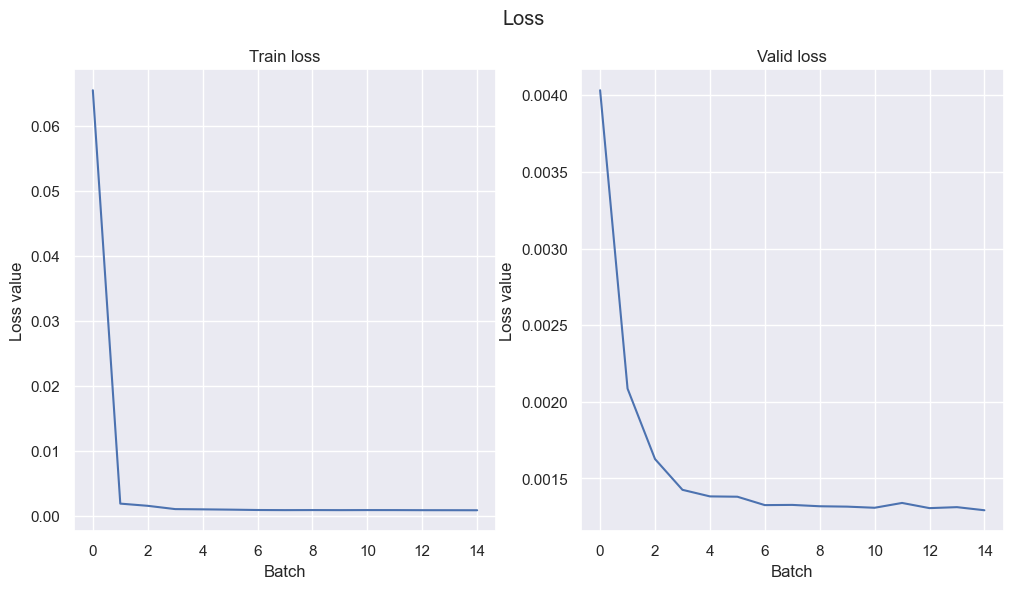

In [12]:
fit_model.plot_graph()

In [13]:
fit_model.filtering_all_images()

100%|██████████| 608/608 [00:01<00:00, 495.50it/s]


In [14]:
fit_model.check_metrics()

After filtering
	SSIM: 0.893
	GMSD: 0.055
Before filtering
	SSIM: 0.697
	GMSD: 0.089
